# Tests and visualizations

## Imports

In [531]:
import numpy as np
import matplotlib.pyplot as plt

## Constants

In [446]:
DATA_PATH = "../data/"
N = 32 # number of columns in data
ratio = 0.9 # ratio of data to use for training
seed = 1 # random seed

## Helpers

In [447]:
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x, mean_x, std_x

In [448]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.
    
    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.
        
    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.
        
    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # set seed
    np.random.seed(seed)
    
    n = y.shape[0]
    nb_tr = int(np.floor(n * ratio))
    
    indices = np.random.permutation(np.arange(n))
    
    x_tr = x[indices[:nb_tr]]
    x_te = x[indices[nb_tr:]]
    y_tr = y[indices[:nb_tr]]
    y_te = y[indices[nb_tr:]]
    
    return x_tr, x_te, y_tr, y_te

In [449]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.
    
    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.
        
    Returns:
        poly: numpy array of shape (N,d+1)
        
    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    n = x.shape[0]
    res = np.zeros((n, degree+1))
    
    for i in range(n):
        for j in range(degree+1):
            res[i, j] = x[i]**j
            
    return res

In [450]:
def compute_loss(y, tx, w):

    """Calculate the loss using MSE

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N, M)
        w: numpy array of shape=(M,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    e = y - tx@w
    n = y.shape[0]
    
    return e.T@e/(2*n)

## Load data

In [451]:
def load_predictions(filename):
    """load data."""
    data = np.loadtxt(DATA_PATH + filename, delimiter=",", skiprows=1, unpack=True, usecols=[1], dtype='str')
    return data

In [452]:
def load_data(filename):
    """load data."""
    data = np.loadtxt(DATA_PATH + filename, delimiter=",", skiprows=1, unpack=True, usecols=np.arange(2, N))
    return data

In [453]:
predictions = load_predictions("train.csv")
data = load_data("train.csv")
print(predictions.shape, data.shape)

(250000,) (30, 250000)


In [454]:
def build_model_data(y, x):
    """Form (y,tX) to get regression data in matrix form."""
    num_samples = len(y)
    fun = lambda e : -1 if e == 'b' else 1 # convert b to -1 and s to 1
    y = [fun(e) for e in y]
    tx = np.c_[np.ones(num_samples), x.T]
    return np.array(y), tx

In [455]:
y, tx_ = build_model_data(predictions, data)
tx_std = standardize(tx_)[0]
print(y.shape, tx_std.shape)

(250000,) (250000, 31)


## Data visualization

Feature 0 in relation to feature 1

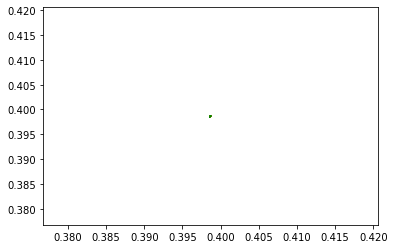

In [534]:
index_a = 0
index_b = 0
y_colors = ['green' if e == -1 else 'orange' for e in y]
plt.scatter(tx_std[:, index_a], tx_std[:, index_b], s=1, c=y_colors)

## Feature expansion

In [499]:
# logs: 4, 6, 8, 13, 14, 25, 26, 27, 28, 29, 30
# poly: 24, 
d = 10
poly = build_poly(tx_std[:, 0], d)
for i in range(1, N-1):
    poly = np.hstack((poly, build_poly(tx_std[:, i], d)[:, 1:]))

tx = poly
print(tx.shape)

(250000, 311)


In [500]:
print(tx)

[[1.00000000e+00 3.98654296e-01 1.58925248e-01 ... 3.67761604e-02
  2.43367277e-02 1.61048981e-02]
 [1.00000000e+00 3.98654296e-01 1.58925248e-01 ... 4.19153634e-03
  2.11431597e-03 1.06651396e-03]
 [1.00000000e+00 3.98654296e-01 1.58925248e-01 ... 3.89414746e-03
  1.94631864e-03 9.72781921e-04]
 ...
 [1.00000000e+00 3.98654296e-01 1.58925248e-01 ... 3.57677417e-03
  1.76879687e-03 8.74710622e-04]
 [1.00000000e+00 3.98654296e-01 1.58925248e-01 ... 6.08596101e-04
  2.41196117e-04 9.55897789e-05]
 [1.00000000e+00 3.98654296e-01 1.58925248e-01 ... 6.08596101e-04
  2.41196117e-04 9.55897789e-05]]


## Split data

In [501]:
tx_tr, tx_te, y_tr, y_te = split_data(tx, y, ratio, seed)
print(tx_tr.shape)
print(tx_te.shape)
print(y_tr.shape)
print(y_te.shape)

(225000, 311)
(25000, 311)
(225000,)
(25000,)


## Implementations

In [502]:
def least_squares(y, tx):
    """Calculate the optimal vector w from the least squares regression, using the normal equations
    
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N, M)
        
    Returns:
        w: the optimal model parameters resulting from the least squares regression
        loss: the MSE loss for the model parameters w.r. to y and tx
    """
    # Normal equations : w* = inverse(tx.T @ tx) @ tx.T @ y -> (tx.T @ tx) @ w* = tx.T @ y
    A = tx.T@tx
    b = tx.T@y
    w = np.linalg.solve(A, b) # Aw = b
    
    loss = compute_loss(y, tx, w)
    
    return (w, loss)

In [503]:
def ridge_regression(y, tx, lambda_):
    """Compute ridge regression using normal equations
    
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.
    
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        loss : the MSE loss for the model parameters w.r. to y and tx
    """
    # Normal equations : w*_ridge = inverse(tx.T @ tx + lambda*I) @ tx.T @ y -> (tx.T @ tx + lambda_prime*I) @ w* = tx.T @ y
    n = y.shape[0]
    d = tx.shape[1]
    lambda_prime = 2*n*lambda_
    
    A = tx.T@tx + lambda_prime*np.identity(d)
    b = tx.T@y
    w = np.linalg.solve(A, b)
    
    loss = compute_loss(y, tx, w) + lambda_*np.sum(w**2)
    
    return (w, loss)

## Training loss in function of lambda

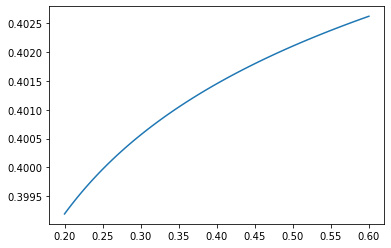

In [518]:
lambdas = np.linspace(0.2, 0.6, 100)
results = [ridge_regression(y_tr, tx_tr, e)[1] for e in lambdas]
plt.plot(lambdas, results)

In [523]:
lambda_ = 0.45
w, loss_train = ridge_regression(y_tr, tx_tr, lambda_)
print(loss_train)

0.4017981055162876


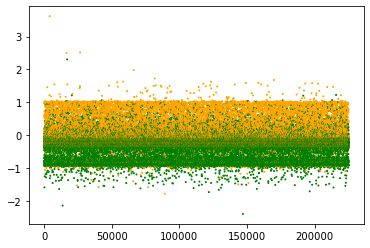

In [524]:
result_train = tx_tr@w
y_train_colors = ['green' if e == -1 else 'orange' for e in y_tr]
plt.scatter(np.arange(0, y_tr.shape[0]), result_train, s=1, c=y_train_colors)

In [525]:
loss_test = compute_loss(y_te, tx_te, w)
print(loss_test)

0.40147979896372044


## Test loss in function of lambda

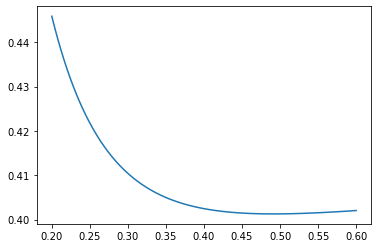

In [514]:
lambdas = np.linspace(0.2, 0.6, 100)
results = [compute_loss(y_te, tx_te, ridge_regression(y_tr, tx_tr, e)[0]) for e in lambdas]
plt.plot(lambdas, results)

(-4.0, 4.0)

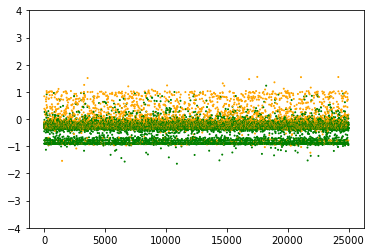

In [522]:
lambda_ = 0.45
w, loss_train = ridge_regression(y_tr, tx_tr, lambda_)
result_test = tx_te@w
y_test_colors = ['green' if e == -1 else 'orange' for e in y_te]
plt.scatter(np.arange(0, y_te.shape[0]), result_test, s=1, c=y_test_colors)